In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
monthly_data = pd.read_csv('monthly_data_cleaned.csv', index_col = 'date')
monthly_data.index = pd.to_datetime(monthly_data.index)
monthly_data.Commodity = monthly_data.Commodity.str.lower()
monthly_data.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price
date,,,,,,,,
2014-09-01,Kurdwadi,sorgum(jawar),2014,September,454,1353,2610,1981
2014-09-01,Satara,ladies finger,2014,September,128,2435,3261,2848
2014-09-01,Satara,potato,2014,September,2988,2175,2488,2331
2014-09-01,Satara,ginger (fresh),2014,September,199,3438,4813,4125
2014-09-01,Satara,ground nut pods (dry),2014,September,1,3000,4000,3500


In order to better understand the task, I'll take one case study (potatoes in Satara) and then generalise a common function for all other clusters of APMC and commodity.

In [3]:
satara_potato = monthly_data[(monthly_data.APMC == 'Satara') & (monthly_data.Commodity == 'potato')]
satara_potato.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price
date,,,,,,,,
2014-09-01,Satara,potato,2014,September,2988,2175,2488,2331
2014-10-01,Satara,potato,2014,October,3160,2067,2567,2317
2014-11-01,Satara,potato,2014,November,3378,2156,2722,2433
2014-12-01,Satara,potato,2014,December,3478,1800,2500,2144
2015-01-01,Satara,potato,2015,January,2005,1075,1650,1363


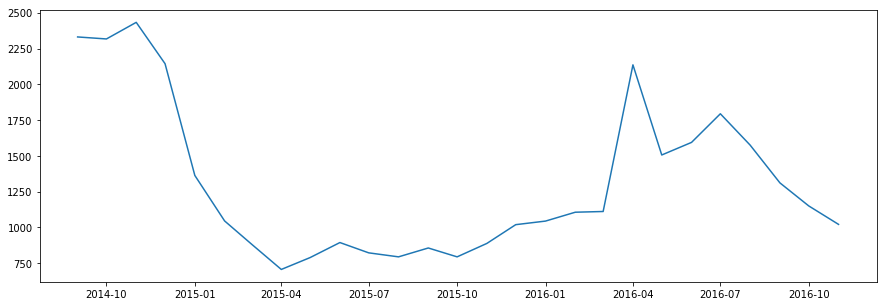

In [4]:
plt.figure(figsize = (15, 5))
plt.plot(satara_potato.modal_price)

Let's check for seasonality in this signal

This is a/an additive type seasonality.


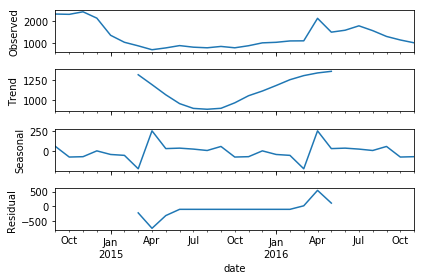

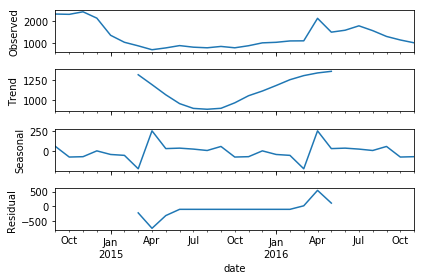

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
decomposition_add = sm.tsa.seasonal_decompose(satara_potato.modal_price, model= 'additive')
decomposition_mult = sm.tsa.seasonal_decompose(satara_potato.modal_price, model= 'multiplicative')

resid_add = decomposition_add.resid
resid_add = resid_add.dropna().values

resid_mult = decomposition_mult.resid
resid_mult = resid_mult.dropna().values

additive_acf = acf(resid_add)
multiplicative_acf = acf(resid_mult)

if additive_acf.all() < multiplicative_acf.all():
    season_type = "additive"
else:
    season_type = "multiplicative"
print("This is a/an " + season_type  + " type seasonality.")
decomposition = sm.tsa.seasonal_decompose(satara_potato.modal_price, model= season_type)
decomposition.plot()

Now I'll try to generalise the steps for each APMC-Commodity cluster.

In [6]:
def identify_seasonality(apmc, commodity):
    timeseries = monthly_data[(monthly_data.APMC == apmc) & (monthly_data.Commodity == commodity)].modal_price
    decomposition_add = sm.tsa.seasonal_decompose(timeseries, model= 'additive')
    decomposition_mult = sm.tsa.seasonal_decompose(timeseries, model= 'multiplicative')

    resid_add = decomposition_add.resid
    resid_add = resid_add.dropna().values

    resid_mult = decomposition_mult.resid
    resid_mult = resid_mult.dropna().values

    additive_acf = acf(resid_add)
    multiplicative_acf = acf(resid_mult)

    if additive_acf.all() < multiplicative_acf.all():
        season_type = "additive"
    else:
        season_type = "multiplicative"
    print("This is a/an " + season_type  + " type seasonality.")
    decomposition = sm.tsa.seasonal_decompose(timeseries, model= season_type)
    decomposition.plot()

Enter an APMC: Kurdwadi
Enter a relevant commodity: sorgum(jawar)
This is a/an additive type seasonality.


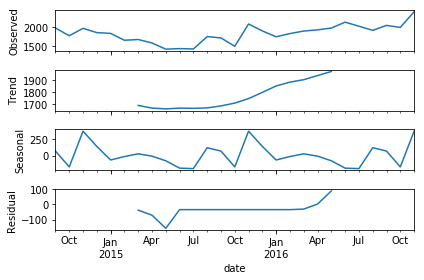

In [7]:
apmc = input("Enter an APMC: ")
commodity = input("Enter a relevant commodity: ")
identify_seasonality(apmc, commodity)

Enter an APMC: Patan
Enter a relevant commodity: brinjal
This is a/an multiplicative type seasonality.


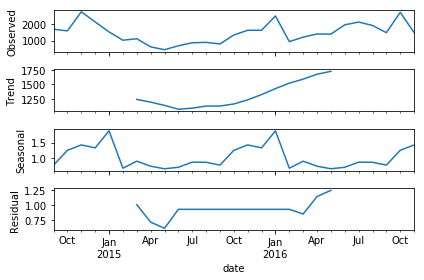

In [8]:
apmc = input("Enter an APMC: ")
commodity = input("Enter a relevant commodity: ")
identify_seasonality(apmc, commodity)

So this is a generalised function which can work for all valid APMC-Commodity clusters. In order to render the deseasonalised signal, I'll have to modify the function a little.

In [9]:
def deseasonalise(apmc, commodity):
    timeseries = monthly_data[(monthly_data.APMC == apmc) & (monthly_data.Commodity == commodity)].modal_price
    decomposition_add = sm.tsa.seasonal_decompose(timeseries, model= 'additive')
    decomposition_mult = sm.tsa.seasonal_decompose(timeseries, model= 'multiplicative')

    resid_add = decomposition_add.resid
    resid_add = resid_add.dropna().values

    resid_mult = decomposition_mult.resid
    resid_mult = resid_mult.dropna().values

    additive_acf = acf(resid_add)
    multiplicative_acf = acf(resid_mult)

    if additive_acf.all() < multiplicative_acf.all():
        season_type = "additive"
    else:
        season_type = "multiplicative"
    print("This is a/an " + season_type  + " type seasonality.")
    decomposition = sm.tsa.seasonal_decompose(timeseries, model= season_type)
    raw = decomposition.observed
    deseasonalised = decomposition.trend
    return raw, deseasonalised

Enter an APMC: Kurdwadi
Enter a relevant commodity: sorgum(jawar)
This is a/an additive type seasonality.


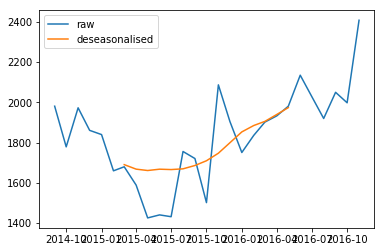

In [10]:
apmc = input("Enter an APMC: ")
commodity = input("Enter a relevant commodity: ")
raw, deseasonalised = deseasonalise(apmc, commodity)
plt.plot(raw, label = 'raw')
plt.plot(deseasonalised, label = 'deseasonalised')
plt.legend(loc = 'best')

So I have created a method to detect the type of seasonality as well as render a deseasonalised output.

Now I need to formulate a method to compare the commodities' MSPs with their raw and deseasonalised prices. MSPs are available in the msp_mandi dataset.

In [11]:
msp_mandi = pd.read_csv('msp_mandi.csv', index_col = 'year')
msp_mandi.head()

,Unnamed: 0,commodity,Type,msprice,msp_filter
year,,,,,
2012,0,PADDY-UNHUSKED,Kharif Crops,1250.0,1
2012,1,RICE(PADDY-HUS),Kharif Crops,1280.0,1
2012,2,Jowar_Hybrid,Kharif Crops,1500.0,1
2012,3,SORGUM(JAWAR),Kharif Crops,1520.0,1
2012,4,BAJRI,Kharif Crops,1175.0,1


In [12]:
msp_mandi.commodity = msp_mandi.commodity.str.lower()
msp_mandi.head()

,Unnamed: 0,commodity,Type,msprice,msp_filter
year,,,,,
2012,0,paddy-unhusked,Kharif Crops,1250.0,1
2012,1,rice(paddy-hus),Kharif Crops,1280.0,1
2012,2,jowar_hybrid,Kharif Crops,1500.0,1
2012,3,sorgum(jawar),Kharif Crops,1520.0,1
2012,4,bajri,Kharif Crops,1175.0,1


Again, to better understand the data, I will take one case study and try to generalise. I'm taking the case of coconuts in Mumbai

In [ ]:
coconut = msp_mandi[msp_mandi.commodity == 'coconut']
coconut.index = pd.to_datetime(coconut.index, format = '%Y')
coconut

In [ ]:
plt.plot(coconut.msprice)

In [ ]:
raw, deseasonalised = deseasonalise('Mumbai', 'coconut')

In [ ]:
plt.plot(coconut.msprice, label = 'MSP')
plt.plot(raw, label = 'Raw Prices')
plt.plot(deseasonalised, label = 'Deseaonalised Prices')
plt.legend(loc = 'best')

This was for a specific case, let's generalise for all APMC-Commodity clusters

In [ ]:
def compare_prices(apmc, commodity):
    msp = msp_mandi[msp_mandi.commodity == commodity]
    msp.index = pd.to_datetime(msp.index, format = '%Y')
    raw, deseasonalised = deseasonalise(apmc, commodity)
    plt.plot(msp.msprice, label = 'MSP')
    plt.plot(raw, label = 'Raw Prices')
    plt.plot(deseasonalised, label = 'Deseasonalised Prices')
    plt.legend(loc = 'best')

In [ ]:
apmc = input("Enter any APMC: ")
commodity = input("Enter any relevant commodity: ")
compare_prices(apmc, commodity)

In [ ]:
msp_mandi.to_csv('msp_mandi.csv')

In [ ]:
monthly_data.to_csv('monthly_data_cleaned.csv')